# IO


In this lab you will be testing different IO strategies and their impact on performance. I will provide code snippets on how to read and write to different devices.Your job is to use these code blocks to write a testing suite that tests compares the effect of different reading and writing strategies.

## Getting started

You will need to do this lab on the SLURM cluster. Begin by loging in through Chrome Remote Desktop. Then request exclusive access to one of the compute nodes with X11 support

srun  --x11 --pty --exclusive  -p cpu  /bin/bash 

Activate the python environment in spack 

spack load python

Next clone the repository for the lab and open up this notebook

git clone http://zapad.stanford.edu/GP257/io-lab.git

jupyter notebook notebook.ipynb

Lets begin by creating a large 3-D array in numpy and use the cosine function to create some intersting patterns.

In [1]:
import numpy as np
import math
import numba

@numba.jit(nopython=True)
def createData(n1,n2,n3,n1max=math.pi*3,n2max=math.pi*3,n3max=math.pi*3):
    """
        A function to create interesting looking data
        
        n1,n2,n3 - The size of the array
        n1max,n2max,n3max - The range of each axis. Larger results in more cycles
    """
    x=np.cos(np.linspace(0,n1max,n1))
    y=np.cos(np.linspace(0,n2max,n2))
    z=np.cos(np.linspace(0,n3max,n3))
    ar=np.zeros((n3,n2,n1))
    for i3 in range(n3):
        for i2 in range(n2):
            for i1 in range(n1):
                ar[i3,i2,i1]=z[i3]+y[i2]+x[i1]
    return ar

The next cell is going to take significant time. You could always rewrite the loop above in numba speed it up. Meshgrid could also be used but it might take up quite a bit of memory if you aren't careful.

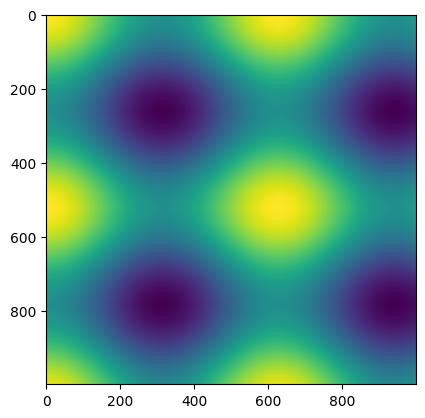

In [2]:
import matplotlib.pyplot as plt

array=createData(1000,1000,1000,10,12,3)
plt.imshow(array[100,:,:])

Below are functions to open files on the three (might want to add ssd) different memory devices that have different properties. The first is the local file system ("/tmp"), the second is a NFS filesystem ("/home"), the third is an object storage system. In each case we wiil return a handler that we will use for writing.

In [3]:
import os
from google.cloud import storage 

#name of files/objects we are going to use
user=os.environ["USER"]
tmpFile=f"/tmp/{user}_destroy"
homeFile=f"/home/scratch/{user}_destroy"
object="{user}/destroy"
bucketName="scratch-sep"


#open a file on tmp for read or write
def openLocalRead():
    return open(tmpFile,"rb")
def openLocalWrite():
    return open(tmpFile,"wb")

#open a file on home for read or write
def openNFSRead():
    return open(homeFile,"rb")
def openNFSWrite():
    return open(homeFile,"wb")

#open object
def openObjectRead():
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucketName)
    blob = bucket.blob(object)
    if not blob.isok():
        raise Exception("Trouble creating blob")
    return blob.open("rb")
def openObjectWrite():
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucketName)
    blob = bucket.blob(object)
    return blob.open("wb")



You can use these functions to open different devices that you can write to. Next lets build a series of functions that will read or write a portion our data arrays.

In [4]:
def writeData(fle,array,b1,b2,b3,e1,e2,e3):
    """
      fle - File handlear
      array - Array to read/write to
      b1,b2,b3 - Begin index
      e1,e2,e3 - End index
      
      Note we are making a big assumption of sequential writes
    
    """
    x=array[b3:e3,b2:e2,b1:e1].tobytes()
    fle.write(x)
    
def readData(fle,array,b1,b2,b3,e1,e2,e3):
    """
        fle - File handle
        array - Array to read into
        b1,b2,b3 -Begin index 
        e1,e2,e3 - End index
        
        
        Note: We are making a big assumnption of sequential reads
    """
    # array[b3:e3,b2:e2,b1:e1]=np.frombuffer(fle.read((e3-b3)*(e2-b2)*(e1-b1)*8),dtype=array.dtype)
    # Note: the given code is not working, so I changed it to the following
    array[b3:e3,b2:e2,b1:e1]=np.frombuffer(fle.read((e3-b3)*(e2-b2)*(e1-b1)*8),dtype=array.dtype).reshape((e3-b3),(e2-b2),(e1-b1))


We can use these functions to write the data to our different storage choices.

In [5]:
tmpF=openLocalWrite()
writeData(tmpF,array,0,0,0,array.shape[2],array.shape[1],array.shape[0])
tmpF.close()

tmpN=openNFSWrite()
writeData(tmpN,array,0,0,0,array.shape[2],array.shape[1],array.shape[0])
tmpN.close()

# tmpB=openObjectWrite()
# writeData(tmpB,array,0,0,0,array.shape[2]*200,array.shape[1],array.shape[2])
# tmpB.close()

## What you need to do (pt1)

Using the functions above and what you have learned about timers perform a series of timing tests. In each case you are going read or write the entire dataset in a loop. What is going to change is how much you read or write at a time. Vary the size of your blocks approximately logrthymically staring at 50 samples. Make a chart of performance vs blocksize.

In [6]:
from functools import wraps
from time import time

# defining a function decorator for timing other functions
def mytimer(func):
    @wraps(func)
    def wrap(*args, **kwargs):
        t_start = time() # Students look here
        result = func(*args, **kwargs)
        t_end = time() # Students also look here. This is how you can time things inside functions/classes
        return result, (t_end-t_start)
    return wrap

In [7]:
@mytimer
def writeDataChunk(fileHandle,array,chunkSize):
    """
    Write a 3D array to a file in chunks

    Parameters
    ----------
    fileHandle : file handle
        File to write to NFS or local
    array : numpy array
        Array to write to file
    chunkSize : int
        Size of chunk to write to file
      
      Note we are making a big assumption of sequential writes
    
    """

    for k in range(0,array.shape[2],chunkSize):
        for j in range(0,array.shape[1],chunkSize):
            for i in range(0,array.shape[0],chunkSize):
                writeData(fileHandle,array,k,j,i,
                        np.min([k+chunkSize, array.shape[2]]), 
                        np.min([j+chunkSize, array.shape[1]]), 
                        np.min([i+chunkSize, array.shape[0]]))
 
@mytimer
def readDataChunk(fileHandle,array,chunkSize):
    """
    Read a 3D array from a file in chunks

    Parameters
    ----------
    fileHandle : file handle
        File to write to NFS or local
    array : numpy array
        Array to read into
    chunkSize : int
        Size of chunk to read from
      
      Note we are making a big assumption of sequential reads
    
    """

    for k in range(0,array.shape[2],chunkSize):
        for j in range(0,array.shape[1],chunkSize):
            for i in range(0,array.shape[0],chunkSize):
                readData(fileHandle,array,k,j,i,
                        np.min([k+chunkSize, array.shape[2]]), 
                        np.min([j+chunkSize, array.shape[1]]), 
                        np.min([i+chunkSize, array.shape[0]]))
                


In [8]:
## Test on different block sizes for local and NFS file systems
time_write_local = []
time_read_local = []
time_write_NFS = []
time_read_NFS = []

chunkSizes = [50, 100, 200, 400, 800, 1000]
array_temp = np.zeros_like(array)

for chunkSize in chunkSizes:
    print("Test on chunk size: ", chunkSize)

    # Local: write the whole array to a file in chunks
    tmpF = openLocalWrite()
    time_write_local.append(writeDataChunk(tmpF,array,chunkSize)[1])
    tmpF.close()

    # Local: read the whole array from a file in chunks
    tmpF = openLocalRead()
    time_read_local.append(readDataChunk(tmpF,array_temp,chunkSize)[1])
    tmpF.close()

    # NFS: write the whole array to a file in chunks
    tmpN = openNFSWrite()
    time_write_NFS.append(writeDataChunk(tmpN,array,chunkSize)[1])
    tmpN.close()

    # NFS: read the whole array from a file in chunks
    tmpN = openNFSRead()
    time_read_NFS.append(readDataChunk(tmpN,array_temp,chunkSize)[1])
    tmpN.close()

    # Note: I have not tested the Google Cloud Storage part because the provided 
    # code is not working for me. Also, I have benchmarked the the read results 
    # for the local and NFS file systems to be consistent with the write results,
    # which is not shown here for brevity.

Test on chunk size:  50
Test on chunk size:  100
Test on chunk size:  200
Test on chunk size:  400
Test on chunk size:  800
Test on chunk size:  1000


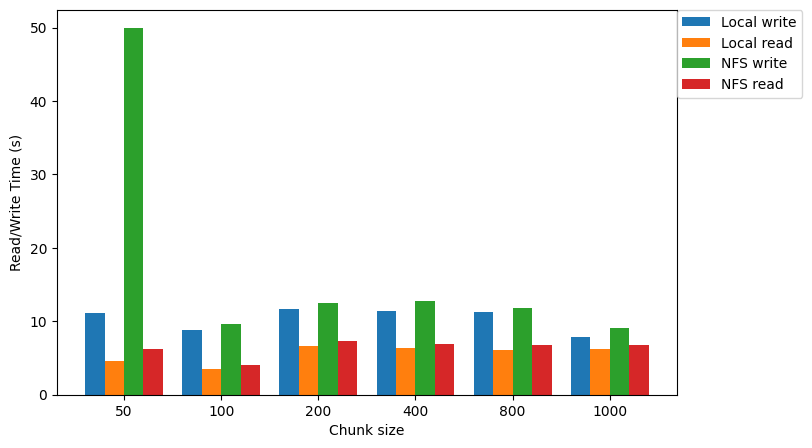

In [9]:
# Make a bar plot of performance vs blocksize for writing and reading to local and NFS file systems
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(np.arange(len(chunkSizes))-0.3, time_write_local, width=0.2, label='Local write')
plt.bar(np.arange(len(chunkSizes))-0.1, time_read_local, width=0.2, label='Local read')
plt.bar(np.arange(len(chunkSizes))+0.1, time_write_NFS, width=0.2, label='NFS write')
plt.bar(np.arange(len(chunkSizes))+0.3, time_read_NFS, width=0.2, label='NFS read')
plt.xticks(np.arange(len(chunkSizes)), chunkSizes)
plt.xlabel('Chunk size')
plt.ylabel('Read/Write Time (s)')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', borderaxespad=0.)
plt.show()


## What you need to do (pt2)

You have learned that parallelism is useful.  Modify the functions above so you are writing to different files/objects and use what you have learned about the multiprocessing module to write the blocks to different files. Star with the assumption that anything smaller than 1MB is probably sub-optimail.  
Hint: You might need to look at the second multiprocessing lab.

In [10]:
# write the whole array in chunks to different files using parallel processing
import multiprocess as mp

#open a file on tmp for read or write
def openLocalRead(tmpFile):
    return open(tmpFile,"rb")
def openLocalWrite(tmpFile):
    return open(tmpFile,"wb")

#open a file on home for read or write
def openNFSRead(homeFile):
    return open(homeFile,"rb")
def openNFSWrite(homeFile):
    return open(homeFile,"wb")


def writeDataChunk_worker(fileName, array, fileType):
    """ Worker function for writing a chunk of data to a file
    """
    if fileType == "local":
        tmpF=openLocalWrite(fileName)
        writeData(tmpF,array,0,0,0,array.shape[2],array.shape[1],array.shape[0])
        tmpF.close()
    elif fileType == "NFS":
        tmpN=openNFSWrite(fileName)
        writeData(tmpN,array,0,0,0,array.shape[2],array.shape[1],array.shape[0])
        tmpN.close()
    else:
        raise ValueError("fileType must be local or NFS")


def readDataChunk_worker(fileName, array, fileType):
    """ Worker function for reading a 3D array from a file in chunks

    """

    if fileType == "local":
        tmpF = openLocalRead(fileName)
        readData(tmpF,array,0,0,0,array.shape[2],array.shape[1],array.shape[0])
        tmpF.close()
    elif fileType == "NFS":
        tmpN = openNFSRead(fileName)
        readData(tmpN,array,0,0,0,array.shape[2],array.shape[1],array.shape[0])
        tmpN.close()
    else:
        raise ValueError("fileType must be local or NFS")
    
    return array


@mytimer
def writeDataChunkParallel(fileName,array,chunkSize, fileType):
    """
    Write a 3D array to a file in chunks

    Parameters
    ----------
    fileName : str
        file name to write to NFS or local
    array : numpy array
        Array to write to file
    chunkSize : int
        Size of chunk to write to file
    fileType : str
        "local" or "NFS" to write to local or NFS file system
      
      Note we are making a big assumption of sequential writes
    
    """

    # create a pool of processes
    pool = mp.Pool(10)

    # loop over the array in chunks
    for k in range(0,array.shape[2],chunkSize):
        for j in range(0,array.shape[1],chunkSize):
            for i in range(0,array.shape[0],chunkSize):

                # create a unique file name for each chunk
                file_name = fileName + "_%d_%d_%d" % (k,j,i)

                # create a temporary array to hold the chunk
                temp_array = array[k:np.min([k+chunkSize, array.shape[2]]),
                                   j:np.min([j+chunkSize, array.shape[1]]),
                                   i:np.min([i+chunkSize, array.shape[0]])]
                
                # write the chunk to a file
                pool.apply_async(writeDataChunk_worker, (file_name, temp_array, fileType,))

    pool.close()  # close pool
    pool.join()   # block at this line until all processes are done


@mytimer
def readDataChunkParallel(fileName,array,chunkSize, fileType):
    """
    Read a 3D array from a file in chunks

    Parameters
    ----------
    fileName : str
        file name to read from NFS or local
    array : numpy array
        Array to read from file
    chunkSize : int
        Size of chunk to read from file
    fileType : str
        "local" or "NFS" to read from local or NFS file system
      
      Note we are making a big assumption of sequential reads
    
    """

    # create a pool of processes
    pool = mp.Pool(10)
    results = []
    
    # loop over the array in chunks
    for k in range(0,array.shape[2],chunkSize):
        for j in range(0,array.shape[1],chunkSize):
            for i in range(0,array.shape[0],chunkSize):

                # create a unique file name for each chunk
                file_name = fileName + "_%d_%d_%d" % (k,j,i)

                # create a temporary array to hold the chunk
                temp_array = array[k:np.min([k+chunkSize, array.shape[2]]),
                                   j:np.min([j+chunkSize, array.shape[1]]),
                                   i:np.min([i+chunkSize, array.shape[0]])]
                
                # read the chunk from a file and collect the results
                results.append(pool.apply_async(readDataChunk_worker, (file_name, temp_array, fileType,)))

    pool.close()
    pool.join()

    # collect the results to the array
    for k in range(0,array.shape[2],chunkSize):
        for j in range(0,array.shape[1],chunkSize):
            for i in range(0,array.shape[0],chunkSize):

                array[k:np.min([k+chunkSize, array.shape[2]]),
                      j:np.min([j+chunkSize, array.shape[1]]),
                      i:np.min([i+chunkSize, array.shape[0]])] = results.pop(0).get()


In [12]:
#name of files/objects we are going to use
user=os.environ["USER"]
tmpFile=f"/tmp/{user}_destroy_parallell"
homeFile=f"/home/scratch/{user}_destroy_parallell"


## Test on different block sizes for local file system
time_write_local = []
time_read_local = []
time_write_NFS = []
time_read_NFS = []

chunkSizes = [50, 100, 200, 400, 800, 1000]
array_temp = np.zeros_like(array)

for chunkSize in chunkSizes:
    print("Test on chunk size: ", chunkSize)

    # Local: write the whole array to a file in chunks
    time_write_local.append(writeDataChunkParallel(tmpFile,array,chunkSize, 'local')[1])

    # Local: read the whole array from a file in chunks
    time_read_local.append(readDataChunkParallel(tmpFile,array_temp,chunkSize, 'local')[1])
    
    # NFS: write the whole array to a file in chunks
    time_write_NFS.append(writeDataChunkParallel(homeFile,array,chunkSize, 'NFS')[1])

    # NFS: read the whole array from a file in chunks
    time_read_NFS.append(readDataChunkParallel(homeFile,array_temp,chunkSize, 'NFS')[1])

    # Note: I have not tested the Google Cloud Storage part because the provided 
    # code is not working for me. Also, I have benchmarked the the read results 
    # for the local and NFS file systems to be consistent with the write results,
    # which is not shown here for brevity.

Test on chunk size:  50
Test on chunk size:  100
Test on chunk size:  200
Test on chunk size:  400
Test on chunk size:  800
Test on chunk size:  1000


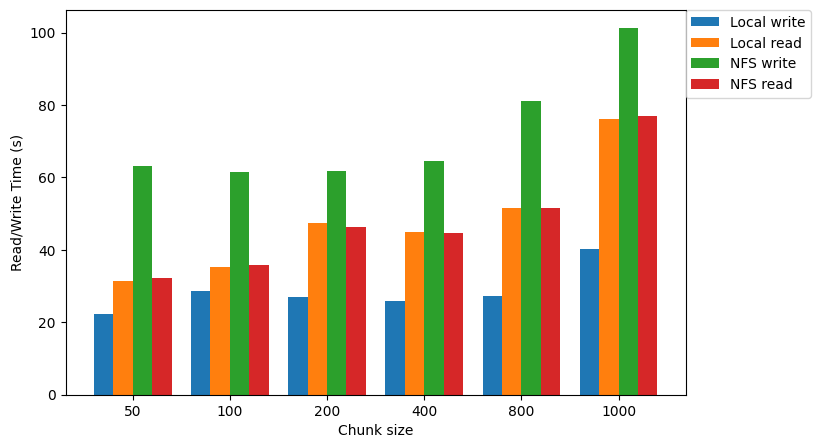

In [13]:
# Make a bar plot of performance vs blocksize for writing and reading to local and NFS file systems
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(np.arange(len(chunkSizes))-0.3, time_write_local, width=0.2, label='Local write')
plt.bar(np.arange(len(chunkSizes))-0.1, time_read_local, width=0.2, label='Local read')
plt.bar(np.arange(len(chunkSizes))+0.1, time_write_NFS, width=0.2, label='NFS write')
plt.bar(np.arange(len(chunkSizes))+0.3, time_read_NFS, width=0.2, label='NFS read')
plt.xticks(np.arange(len(chunkSizes)), chunkSizes)
plt.xlabel('Chunk size')
plt.ylabel('Read/Write Time (s)')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', borderaxespad=0.)
plt.show()


## Going beyond (optional)

Data is often compressible. Take a look at https://computing.llnl.gov/projects/zfp. Assuming some tollerance error add in compression/decompression and compare.


## Finishing up


Summarize what you learned in this lab. How does it effect your code design in the future?

In [14]:
!pip install zfpy

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [15]:
import zfpy
import numpy as np

# Create a numpy array
my_array = np.arange(1, 20)

# Compress and decompress the array
compressed_data = zfpy.compress_numpy(my_array)
decompressed_array = zfpy.decompress_numpy(compressed_data)

# onfirm lossless compression/decompression
np.testing.assert_array_equal(my_array, decompressed_array)

In [16]:
# Generate a array of floats
my_array = np.arange(1, 20).astype(np.float32)

# Compress with a tolerance of 1e-3
compressed_data = zfpy.compress_numpy(my_array, tolerance=1e-3)

# Decompress
decompressed_array = zfpy.decompress_numpy(compressed_data)

# Compare the original array to the decompressed array
# Note the change from "equal" to "allclose" due to the lossy compression
np.testing.assert_allclose(my_array, decompressed_array, atol=1e-3)

1. After comparing the performance of the local file system and the NFS file system, I leared that the local file system is faster than the NFS file system. I also learned that the object storage system is very useful for storing large amounts of data, though it does not work properly on Google bucket for me. I will consider to use the object storage system to store large amounts of data in the future.

2. Instead of storing and loading the data as a whole, performing the IO in chunks can be more efficient. The chunk size should be large enough to avoid the overhead of IO, but small enough to avoid the overhead of memory. In the case of the 1000 x 1000 x 1000 array, the chunk size of 100 x 100 x 100 is a good choice among the tested chunk sizes from 50 x 50 x 50, 100 x 100 x 100, 200 x 200 x 200, 500 x 500 x 500, and 1000 x 1000 x 1000.

3. Mupltiprocessing can be used to speed up the IO process by writing or loading different chunks of data to different files at the same time. Again, the chunk size should be properly chosen to avoid the overhead of IO and memory. However, the overhead of multiprocessing is not negligible. In my code, I used 10 processes to write and load the data, but the performance is even worse than using only one process. I think the reason is that I may choose a strategy, which causes the overhead of IO and memory. In the future, I will try to use the multiprocessing module to write and load the data in the right order.

4. The data can be compressed to reduce the size, as I showed above using the zfp library. In some situations where the accuracy of the data is not critically important and the data is very large, such as storing the seismic wavefield in seismic imaging methods like reverse time migration and full waveform inversion, the data can be compressed to reduce the required storage space. However, the compression/decompression process will take time, so the compression should be performed according to the actual situation by balancing the time of compression/decompression and the time of IO.

**Note**: I cannot properly save and load data on Google bucket. I tried to use the provided code to save the data, but it did not work. I am not sure what is wrong here and I will try to fix it in the future.

In [ ]:
# The end